# Imports

In [1]:
from __future__ import print_function

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import shuffle as sfl
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


# Settings

In [22]:
batch_size = 200  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'Corpus/train2000verbs.csv'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


## Token Dictionaries 

In [19]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# Encoder-Decoder

In [20]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=False)

In [24]:
# Save model
model.save_weights('Untitled Folder/2000samples.h5')

### Plots 

In [25]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


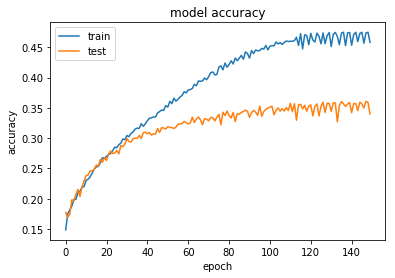

In [26]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### Batch = 200, Samples = 2000, Epochs = 150, Time = 17 min

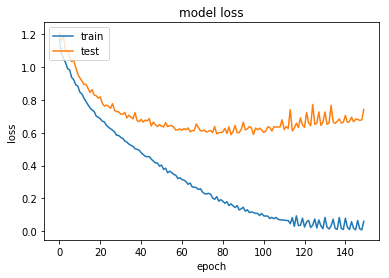

In [27]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [28]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [29]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# Decode Sequence 

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

## Testing it on a part of the traning set 

In [31]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sertuio

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estraio

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: particio

-
Input sentence: comer
Decoded sentence: comero

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: cantraliço

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sen

## Test it on the test data set

In [32]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [34]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('Models/2000samples.h5')

In [35]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

In [36]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [37]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [38]:
test

,infinitivo,conjugado,enconding
0,salgar,salgo,salto\n
1,barrar,barro,brarco\n
2,urinar,urino,urando\n
3,inquirir,inquiro,inibo\n
4,empobrecer,empobreço,empordo\n
5,alumiar,alumio,alum\n
6,abreviar,abrevio,abareo\n
7,folhar,folho,folheio\n
8,desprover,desprovo,desperto\n
9,reconvir,reconvenho,recinço\n


# Change Hyperparameters 

In [76]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

In [77]:
def load_train_test(corpus = complete_corpus_path, num_samples = num_samples, test_size = test_size):
    with open(corpus, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    train_data = lines[:num_samples]
    test_data = lines[:test_size]
    train_file = 'Corpus/train' + str(num_samples) + 'verbs.csv'
    test_file = 'Corpus/test' + str(test_size) + 'verbs.csv'
    
    with open(train_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(test_file, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    return train_file, test_file

In [78]:
train_file, test_file = load_train_test()

In [79]:
train_file

'Corpus/train3000verbs.csv'

In [80]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [81]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


In [82]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [83]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [12]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [169]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.29809, saving model to Models/model2.h5
17s - loss: 1.3149 - acc: 0.1147 - val_loss: 1.2981 - val_acc: 0.1245
Epoch 2/100
Epoch 00001: val_loss improved from 1.29809 to 1.24788, saving model to Models/model2.h5
13s - loss: 1.2027 - acc: 0.1356 - val_loss: 1.2479 - val_acc: 0.1734
Epoch 3/100
Epoch 00002: val_loss improved from 1.24788 to 1.15077, saving model to Models/model2.h5
13s - loss: 1.1240 - acc: 0.1735 - val_loss: 1.1508 - val_acc: 0.1931
Epoch 4/100
Epoch 00003: val_loss improved from 1.15077 to 1.08460, saving model to Models/model2.h5
13s - loss: 1.0385 - acc: 0.1927 - val_loss: 1.0846 - val_acc: 0.2021
Epoch 5/100
Epoch 00004: val_loss improved from 1.08460 to 1.01569, saving model to Models/model2.h5
13s - loss: 0.9679 - acc: 0.2045 - val_loss: 1.0157 - val_acc: 0.2146
Epoch 6/100
Epoch 00005: val_loss improved from 1.01569 to 0.95540, saving model to Models/model2.h5
1

In [13]:
# Save model
save_path = '3000samplesweights.h5'
model.save_weights('Models/' + save_path)

### Plots 

In [170]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Batch = 64, Samples = 3000, Epochs = 100, Time = 21 min

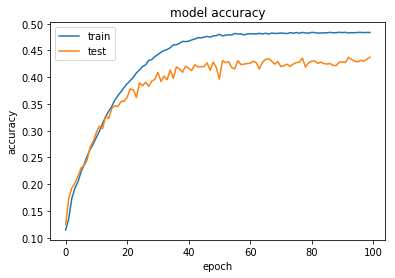

In [171]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

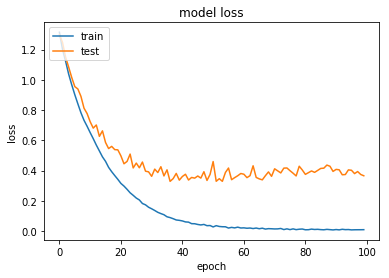

In [172]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [13]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [14]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [178]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero

-


## Test it on the test data set

In [15]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [16]:
# Restore the model and construct the encoder and decoder.
model = load_model('Models/model2.h5')

encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vio

-
Input sentence: ser
Decoded sentence: souo

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estouo

-
Input sentence: ver
Decoded sentence: vero

-
Input sentence: vir
Decoded sentence: vo

-
Input sentence: ter
Decoded sentence: teio

-
Input sentence: poder
Decoded sentence: poso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: heio

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: dizo

-
Input sentence: estudar
Decoded sentence: estuo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: sio

-
Input sentence: querer
Decoded sentence: quero

-
Inpu

In [20]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

In [24]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [25]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [26]:
test

,infinitivo,conjugado,enconding
0,chantar,chanto,chatenho\n
1,depenicar,depenico,depencio\n
2,desenferrujar,desenferrujo,desenfuro\n
3,despoluir,despoluo,despoluo\n
4,desquitar,desquito,desibuto\n
5,destecer,desteço,desecto\n
6,dorir,doro,dorio\n
7,emascular,emasculo,embasco\n
8,enlutar,enluto,enuloto\n
9,espigar,espigo,espio\n


floyd run --mode jupyter --cpu --env keras

## Increase Sample 

In [87]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 4800  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

In [88]:
def load_train_test(corpus = complete_corpus_path, num_samples = num_samples, test_size = test_size):
    with open(corpus, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    train_data = lines[:num_samples]
    test_data = lines[:test_size]
    train_file = 'Corpus/train' + str(num_samples) + 'verbs.csv'
    test_file = 'Corpus/test' + str(test_size) + 'verbs.csv'
    
    with open(train_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(test_file, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    return train_file, test_file

In [89]:
train_file, test_file = load_train_test()

In [90]:
train_file

'Corpus/train4800verbs.csv'

In [91]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [92]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 4800
Number of unique input tokens: 27
Number of unique output tokens: 32
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [93]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [94]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [96]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model3.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [97]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 3840 samples, validate on 960 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.02541, saving model to Models/model3.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 20s - loss: 1.0032 - acc: 0.0895 - val_loss: 1.0254 - val_acc: 0.1046
Epoch 2/100
Epoch 00002: val_loss improved from 1.02541 to 0.91397, saving model to Models/model3.h5
 - 20s - loss: 0.9049 - acc: 0.1237 - val_loss: 0.9140 - val_acc: 0.1438
Epoch 3/100
Epoch 00003: val_loss improved from 0.91397 to 0.82556, saving model to Models/model3.h5
 - 21s - loss: 0.8129 - acc: 0.1432 - val_loss: 0.8256 - val_acc: 0.1650
Epoch 4/100
Epoch 00004: val_loss improved from 0.82556 to 0.74754, saving model to Models/model3.h5
 - 20s - loss: 0.7337 - acc: 0.1615 - val_loss: 0.7475 - val_acc: 0.1740
Epoch 5/100
Epoch 00005: val_loss improved from 0.74754 to 0.72864, saving model to Models/model3.h5
 - 20s - loss: 0.6721 - acc: 0.1771 - val_loss: 0.7286 - val_acc: 0.1835
Epoch 6/100
Epoch 00006: val_loss improved from 0.72864 to 0.65727, saving model to Models/model3.h5
 - 22s - loss: 0.6335 - acc: 0.1880 - val_loss: 0.6573 - val_acc: 0.2022
Epoch 7/100
Epoch 00007: val_loss improved from 0.65727 t

In [98]:
# Save model
save_path = '4000samplesweights.h5'
model.save_weights('Models/' + save_path)

### Plots 

In [99]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Batch = 64, Samples = 4000, Epochs = 100, Time = 1h30

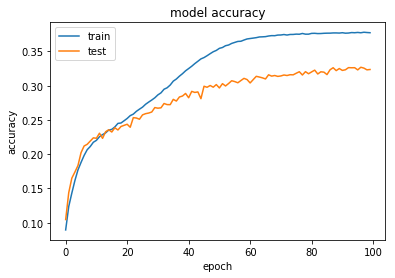

In [100]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

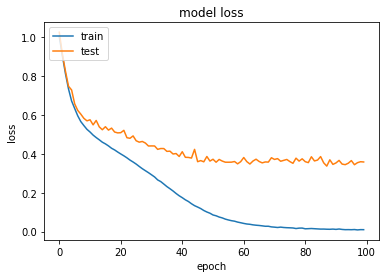

In [101]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [102]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [103]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [104]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: vinoo

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: compino

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero


## Test it on the test data set

In [105]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [106]:
# Restore the model and construct the encoder and decoder.
model = load_model('Models/model3.h5')

encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [107]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estauo

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: partigo

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero


In [108]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

In [109]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [110]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [111]:
test

,infinitivo,conjugado,enconding
0,ir,vou,vou\n
1,ser,sou,sou\n
2,fazer,faço,faço\n
3,amar,amo,amo\n
4,estar,estou,estauo\n
5,ver,vejo,vejo\n
6,vir,venho,venho\n
7,ter,tenho,tenho\n
8,poder,posso,posso\n
9,dar,dou,dou\n


# Phonetic Transcription 

In [36]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 325  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/train_lstm_corpus.csv'

In [37]:
def load_train_test(corpus = complete_corpus_path, num_samples = num_samples, test_size = test_size):
    with open(corpus, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    train_data = lines[:num_samples]
    test_data = lines[:test_size]
    train_file = 'Corpus/train' + str(num_samples) + 'verbs.csv'
    test_file = 'Corpus/test' + str(test_size) + 'verbs.csv'
    
    with open(train_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(test_file, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    return train_file, test_file

In [38]:
train_file, test_file = load_train_test()

In [39]:
train_file

'Corpus/train325verbs.csv'

In [40]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [41]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 325
Number of unique input tokens: 22
Number of unique output tokens: 26
Max sequence length for inputs: 11
Max sequence length for outputs: 13


In [42]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [43]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [44]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [70]:
encoder_input_data.shape

(325, 11, 22)

In [71]:
decoder_input_data.shape

(325, 13, 26)

In [45]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 260 samples, validate on 65 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.66036, saving model to Models/model2.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 2s - loss: 1.8611 - acc: 0.1160 - val_loss: 1.6604 - val_acc: 0.0556
Epoch 2/100
Epoch 00002: val_loss improved from 1.66036 to 1.51229, saving model to Models/model2.h5
 - 1s - loss: 1.5850 - acc: 0.1192 - val_loss: 1.5123 - val_acc: 0.1633
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 1s - loss: 1.5467 - acc: 0.1269 - val_loss: 1.5519 - val_acc: 0.1373
Epoch 4/100
Epoch 00004: val_loss improved from 1.51229 to 1.46584, saving model to Models/model2.h5
 - 1s - loss: 1.5422 - acc: 0.1322 - val_loss: 1.4658 - val_acc: 0.1598
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 1s - loss: 1.5063 - acc: 0.1376 - val_loss: 1.5459 - val_acc: 0.1361
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 1s - loss: 1.5123 - acc: 0.1331 - val_loss: 1.5434 - val_acc: 0.1349
Epoch 7/100
Epoch 00007: val_loss improved from 1.46584 to 1.46485, saving model to Models/model2.h5
 - 1s - loss: 1.5209 - acc: 0.1420 - val_loss: 1.4649 - val_acc: 0.1657
Epoch 8/100
Epoch 00008: val_loss did not i

In [46]:
# Save model
save_path = '325samplesweights.h5'
model.save_weights('Models/' + save_path)

### Plots 

In [47]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Batch = 64, Samples = 325, Epochs = 100, Time = 3 min

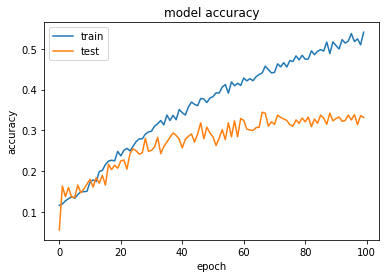

In [48]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

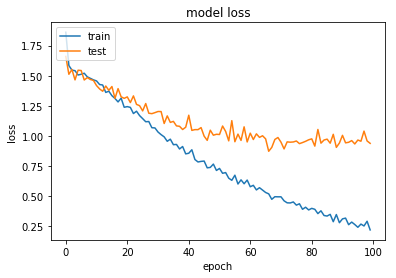

In [49]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [50]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [51]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [52]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ansia
Decoded sentence: ansiiu

-
Input sentence: pleitea
Decoded sentence: peeiiu

-
Input sentence: insendia
Decoded sentence: insisu

-
Input sentence: sortea
Decoded sentence: sosteiu

-
Input sentence: hemedia
Decoded sentence: heeeiu

-
Input sentence: intermedia
Decoded sentence: interdegu

-
Input sentence: pasea
Decoded sentence: pasu

-
Input sentence: olia
Decoded sentence: linu

-
Input sentence: koloka
Decoded sentence: kOlOku

-
Input sentence: informa
Decoded sentence: infOrmu

-
Input sentence: torna
Decoded sentence: trOnu

-
Input sentence: mostra
Decoded sentence: mOstu

-
Input sentence: tostar
Decoded sentence: tOstu

-
Input sentence: troka
Decoded sentence: trOku

-
Input sentence: heboka
Decoded sentence: hebu

-
Input sentence: soka
Decoded sentence: sOsu

-
Input sentence: kosa
Decoded sentence: kOsu

-
Input sentence: toma
Decoded sentence: tOsu

-
Input sentence: hekorta
Decoded sentence: hekOrtu

-
Input sentence: entorta
Decoded sentence:

## Test it on the test data set

In [53]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [54]:
# Restore the model and construct the encoder and decoder.
model = load_model('Models/model2.h5')

encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [55]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ansia
Decoded sentence: aniu

-
Input sentence: pleitea
Decoded sentence: peeiu

-
Input sentence: insendia
Decoded sentence: insintu

-
Input sentence: sortea
Decoded sentence: prstu

-
Input sentence: hemedia
Decoded sentence: hekoniu

-
Input sentence: intermedia
Decoded sentence: intrrveju

-
Input sentence: pasea
Decoded sentence: pasu

-
Input sentence: olia
Decoded sentence: kOu

-
Input sentence: koloka
Decoded sentence: komOku

-
Input sentence: informa
Decoded sentence: infiru

-
Input sentence: torna
Decoded sentence: tOrtu

-
Input sentence: mostra
Decoded sentence: pOstu

-
Input sentence: tostar
Decoded sentence: tOstu

-
Input sentence: troka
Decoded sentence: tOru

-
Input sentence: heboka
Decoded sentence: hekubu

-
Input sentence: soka
Decoded sentence: sOku

-
Input sentence: kosa
Decoded sentence: kOku

-
Input sentence: toma
Decoded sentence: tOstu

-
Input sentence: hekorta
Decoded sentence: hekOru

-
Input sentence: entorta
Decoded sentence: ent

In [57]:
decode_sequence(encode_sequence("eskurese"))

'esku\n'

In [58]:
test_file

'Corpus/test100verbs.csv'

In [59]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [60]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [61]:
test

,infinitivo,conjugado,enconding
0,ansia,anseiu,aniu\n
1,pleitea,pleiteiu,peeiu\n
2,insendia,insendeiu,insintu\n
3,sortea,sorteiu,prstu\n
4,hemedia,hemedeiu,hekoniu\n
5,intermedia,intermedeiu,intrrveju\n
6,pasea,paseiu,pasu\n
7,olia,Oliu,kOu\n
8,koloka,kolOku,komOku\n
9,informa,infOrmu,infiru\n


# Grid Search 

## Batch Size and Epochs 

In [84]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='accuracy')
grid_result = grid.fit(encoder_input_data, decoder_input_data)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: Cannot clone object '<keras.engine.training.Model object at 0x117092ba8>' (type <class 'keras.engine.training.Model'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [66]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

In [86]:
encoder_input_data.shape

(3000, 15, 26)

# Activation RELU + Dropout

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

def load_train_test(corpus = complete_corpus_path, num_samples = num_samples, test_size = test_size):
    with open(corpus, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    train_data = lines[:num_samples]
    test_data = lines[:test_size]
    train_file = 'Corpus/train' + str(num_samples) + 'verbs.csv'
    test_file = 'Corpus/test' + str(test_size) + 'verbs.csv'
    
    with open(train_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(test_file, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    return train_file, test_file

train_file, test_file = load_train_test()

train_file

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, recurrent_dropout=0.25)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model4.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

TypeError: list indices must be integers or slices, not tuple

In [169]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.29809, saving model to Models/model2.h5
17s - loss: 1.3149 - acc: 0.1147 - val_loss: 1.2981 - val_acc: 0.1245
Epoch 2/100
Epoch 00001: val_loss improved from 1.29809 to 1.24788, saving model to Models/model2.h5
13s - loss: 1.2027 - acc: 0.1356 - val_loss: 1.2479 - val_acc: 0.1734
Epoch 3/100
Epoch 00002: val_loss improved from 1.24788 to 1.15077, saving model to Models/model2.h5
13s - loss: 1.1240 - acc: 0.1735 - val_loss: 1.1508 - val_acc: 0.1931
Epoch 4/100
Epoch 00003: val_loss improved from 1.15077 to 1.08460, saving model to Models/model2.h5
13s - loss: 1.0385 - acc: 0.1927 - val_loss: 1.0846 - val_acc: 0.2021
Epoch 5/100
Epoch 00004: val_loss improved from 1.08460 to 1.01569, saving model to Models/model2.h5
13s - loss: 0.9679 - acc: 0.2045 - val_loss: 1.0157 - val_acc: 0.2146
Epoch 6/100
Epoch 00005: val_loss improved from 1.01569 to 0.95540, saving model to Models/model2.h5
1

In [13]:
# Save model
save_path = '3000samples_relu_dropout_0.25.h5'
model.save_weights('Models/' + save_path)

### Plots 

In [170]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Batch = 64, Samples = 3000, Epochs = 100, Time = 21 min

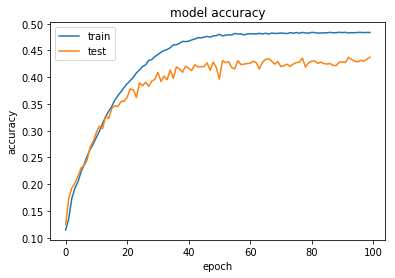

In [171]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

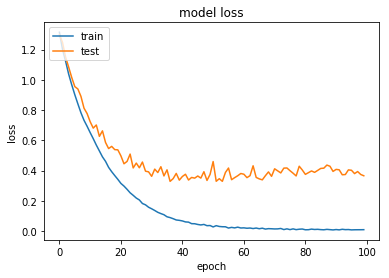

In [172]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [13]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [14]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [178]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero

-


## Test it on the test data set

In [15]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [16]:
# Restore the model and construct the encoder and decoder.
model = load_model('Models/model2.h5')

encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vio

-
Input sentence: ser
Decoded sentence: souo

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estouo

-
Input sentence: ver
Decoded sentence: vero

-
Input sentence: vir
Decoded sentence: vo

-
Input sentence: ter
Decoded sentence: teio

-
Input sentence: poder
Decoded sentence: poso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: heio

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: dizo

-
Input sentence: estudar
Decoded sentence: estuo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: sio

-
Input sentence: querer
Decoded sentence: quero

-
Inpu

In [20]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

In [24]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [25]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [26]:
test

,infinitivo,conjugado,enconding
0,chantar,chanto,chatenho\n
1,depenicar,depenico,depencio\n
2,desenferrujar,desenferrujo,desenfuro\n
3,despoluir,despoluo,despoluo\n
4,desquitar,desquito,desibuto\n
5,destecer,desteço,desecto\n
6,dorir,doro,dorio\n
7,emascular,emasculo,embasco\n
8,enlutar,enluto,enuloto\n
9,espigar,espigo,espio\n


In [76]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

In [77]:
def load_train_test(corpus = complete_corpus_path, num_samples = num_samples, test_size = test_size):
    with open(corpus, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    train_data = lines[:num_samples]
    test_data = lines[:test_size]
    train_file = 'Corpus/train' + str(num_samples) + 'verbs.csv'
    test_file = 'Corpus/test' + str(test_size) + 'verbs.csv'
    
    with open(train_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(line + '\n')
    
    with open(test_file, 'w', encoding='utf-8') as f:
        for line in test_data:
            f.write(line + '\n')
    return train_file, test_file

In [78]:
train_file, test_file = load_train_test()

In [79]:
train_file

'Corpus/train3000verbs.csv'

In [80]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [81]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


In [82]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [83]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [12]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [169]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.29809, saving model to Models/model2.h5
17s - loss: 1.3149 - acc: 0.1147 - val_loss: 1.2981 - val_acc: 0.1245
Epoch 2/100
Epoch 00001: val_loss improved from 1.29809 to 1.24788, saving model to Models/model2.h5
13s - loss: 1.2027 - acc: 0.1356 - val_loss: 1.2479 - val_acc: 0.1734
Epoch 3/100
Epoch 00002: val_loss improved from 1.24788 to 1.15077, saving model to Models/model2.h5
13s - loss: 1.1240 - acc: 0.1735 - val_loss: 1.1508 - val_acc: 0.1931
Epoch 4/100
Epoch 00003: val_loss improved from 1.15077 to 1.08460, saving model to Models/model2.h5
13s - loss: 1.0385 - acc: 0.1927 - val_loss: 1.0846 - val_acc: 0.2021
Epoch 5/100
Epoch 00004: val_loss improved from 1.08460 to 1.01569, saving model to Models/model2.h5
13s - loss: 0.9679 - acc: 0.2045 - val_loss: 1.0157 - val_acc: 0.2146
Epoch 6/100
Epoch 00005: val_loss improved from 1.01569 to 0.95540, saving model to Models/model2.h5
1

In [13]:
# Save model
save_path = '3000samplesweights.h5'
model.save_weights('Models/' + save_path)

### Plots 

In [170]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


### Batch = 64, Samples = 3000, Epochs = 100, Time = 21 min

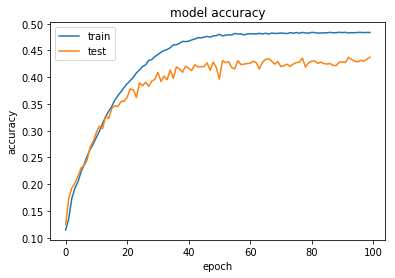

In [171]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

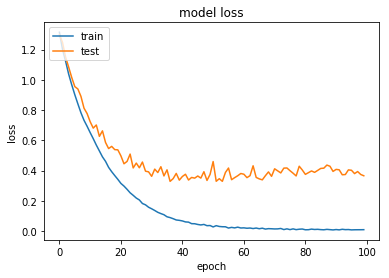

In [172]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [13]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [14]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [178]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero

-


## Test it on the test data set

In [15]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

### Load Trained Model 

In [16]:
# Restore the model and construct the encoder and decoder.
model = load_model('Models/model2.h5')

encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vio

-
Input sentence: ser
Decoded sentence: souo

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estouo

-
Input sentence: ver
Decoded sentence: vero

-
Input sentence: vir
Decoded sentence: vo

-
Input sentence: ter
Decoded sentence: teio

-
Input sentence: poder
Decoded sentence: poso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: heio

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: dizo

-
Input sentence: estudar
Decoded sentence: estuo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: sio

-
Input sentence: querer
Decoded sentence: quero

-
Inpu

In [20]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

In [24]:
import pandas as pd

test = pd.read_csv('Corpus/test100verbs.csv', 
                   sep=';', names=['infinitivo','conjugado'])

In [25]:
test['enconding'] = test.infinitivo.apply(encode_sequence).apply(decode_sequence)

In [26]:
test

,infinitivo,conjugado,enconding
0,chantar,chanto,chatenho\n
1,depenicar,depenico,depencio\n
2,desenferrujar,desenferrujo,desenfuro\n
3,despoluir,despoluo,despoluo\n
4,desquitar,desquito,desibuto\n
5,destecer,desteço,desecto\n
6,dorir,doro,dorio\n
7,emascular,emasculo,embasco\n
8,enlutar,enluto,enuloto\n
9,espigar,espigo,espio\n


# Refazer os testes do modelo3 pq ele carregou a base de testes errado 

# Testar o melhor modelo com dropout e realizer o Grid Search 

# Passar os verbos pro transcritor